Implementation of the mutual information neural estimator (MINE) in JAX.

The MINE estimates the mutual information between a pair of jointly distributed vairables $(X,Y)∼P_{XY}$ by leveraging the Donsker-Varadhan variational representation, which is transferred to an optimization problem over neural networks by estimating expectations with sample means.

The MINE optimization problem is given by ($\bar{Y}$ is a saple of the marginal)

$\hat{I}(X^n,Y^n) = \sup_{f_{\theta}} \frac{1}{n}\sum_{i=1}^n f_{\theta}(X_i,Y_i) - \log \left( \frac{1}{n} \sum_{i=1}^n \exp(f_{\theta}(X_i,\bar{Y}_i)) \right) $

In [60]:
import jax
import jax.numpy as jnpx
import flax.linen as nn
from jax.random import PRNGKey, multivariate_normal
import optax
from jax import grad, jit
from jax.random import split
from flax.training import train_state
import math
import matplotlib.pyplot as plt

Generate a $d$-dimensional correlated Gaussian dataet with correlation coefficient $\rho$. Gaussians are cenetered.

In [12]:
def create_gaussian_dataset_d(rho, d, num_samples, key):
    # Mean vector for the 2d-dimensional multivariate Gaussian
    mean = jnp.zeros(2 * d)

    # Covariance matrix
    identity_d = jnp.eye(d)
    cross_corr = rho * jnp.eye(d)  # Correlation between X and Y
    covariance = jnp.block([
        [identity_d, cross_corr],  # Covariance between X and Y
        [cross_corr, identity_d]   # Covariance between Y and X
    ])

    # Generate samples
    samples = multivariate_normal(key, mean, covariance, shape=(num_samples,))

    # Split samples into X and Y
    x = samples[:, :d]
    y = samples[:, d:]
    return x, y

Generate a simple shallow ReLU MLP for the MINE. The MINE network maps the cancatenated pair $(x,y)$ to a one-dimensional output, which is, optimally, an esimate of the LLR $f_{\theta}^\star = \frac{P_{XY}(x,y)}{P_X(x)P_Y(y)}$.

In [51]:
class MINE(nn.Module):
    """
    A simple MINE network with ReLU activations.

    Attributes:
        hidden_dim (int): Number of hidden units in each layer.
        output_dim (int): Dimension of the output, should be 1 for MINE.
        num_layers (int): Number of hidden layers.
    """
    hidden_dim: int
    output_dim: int = 1
    num_layers: int = 2

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for _ in range(self.num_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = nn.relu(x)
        x = nn.Dense(self.output_dim)(x)
        return x

def mine_loss(params, apply_fn, x, y, rng):
    """
    Computes the MINE loss based on the Donsker-Varadhan representation.

    Parameters:
        params: Model parameters.
        apply_fn: Function to apply the MINE model.
        x, y: Input Gaussian vectors (x and y are d-dimensional).
        rng: Random key for shuffling.

    Returns:
        loss: The MINE loss, a lower bound on mutual information.
    """
    batch_size = x.shape[0]
    inputs = jnp.concatenate([x, y], axis=-1)  # Positive pairs: (x, y)

    # Shuffle y for negative samples
    y_shuffled = jax.random.permutation(rng, y)
    neg_inputs = jnp.concatenate([x, y_shuffled], axis=-1)  # Negative pairs: (x, y_shuffled)

    # Compute T(x, y) and T(x, y_shuffled)
    # The fix: Pass params directly instead of nesting it in another dictionary
    t_xy = apply_fn(params, inputs).squeeze()
    t_x_y_shuffled = apply_fn(params, neg_inputs).squeeze()

    # Donsker-Varadhan representation
    term_1 = jnp.mean(t_xy)
    term_2 = jnp.log(jnp.mean(jnp.exp(t_x_y_shuffled)))
    loss = -(term_1 - term_2)
    return loss

@jit
def train_step(state, x, y, rng):
    """
    Perform a single training step for the MINE model.

    Parameters:
        state: Train state containing the optimizer and parameters.
        x, y: Input Gaussian vectors.
        rng: Random key for negative sample generation.

    Returns:
        Updated state and loss value.
    """
    def loss_fn(params):
        return mine_loss(params, state.apply_fn, x, y, rng)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [79]:
# Dataset parameters
rho = 0.7
d = 3
num_samples = 10000
batch_size = 64
key = PRNGKey(0)
num_epochs = 100

# Generate dataset
# x, y = create_gaussian_dataset(rho, num_samples, key)
x, y = create_gaussian_dataset_d(rho, d, num_samples, key)
train_key, shuffle_key = split(key)

# Model setup
model = MINE(hidden_dim=30, num_layers=3)
x_sample = jnp.ones((batch_size, 2 * d))  # Example input for initialization
params = model.init(train_key, x_sample)

# Optimizer and state
optimizer = optax.adam(learning_rate=5e-5)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

num_batches = math.ceil(num_samples / batch_size)

loss = []

for epoch in range(num_epochs):
    # Shuffle dataset at the beginning of each epoch
    shuffle_key, subkey = split(shuffle_key)
    perm = jax.random.permutation(subkey, num_samples)
    x_shuffled = x[perm]
    y_shuffled = y[perm]

    epoch_loss = 0.0  # Accumulate loss over the epoch

    for i in range(num_batches):
        # Mini-batch sampling
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, num_samples)
        x_batch = x_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]

        # Training step
        step_rng, shuffle_key = split(shuffle_key)
        state, batch_loss = train_step(state, x_batch, y_batch, step_rng)
        epoch_loss -= batch_loss * (end_idx - start_idx)  # Weighted sum for average loss

    # Compute average loss for the epoch
    epoch_loss /= num_samples

    loss.append(epoch_loss)

    # Print epoch loss
    # if epoch % 50 == 0:
    print(f"Epoch {epoch}, Average Loss: {epoch_loss:.4f}")

print("Training complete!")

Epoch 0, Average Loss: 0.0325
Epoch 1, Average Loss: 0.0824
Epoch 2, Average Loss: 0.1323
Epoch 3, Average Loss: 0.1895
Epoch 4, Average Loss: 0.2649
Epoch 5, Average Loss: 0.3478
Epoch 6, Average Loss: 0.4233
Epoch 7, Average Loss: 0.5112
Epoch 8, Average Loss: 0.5750
Epoch 9, Average Loss: 0.6392
Epoch 10, Average Loss: 0.6890
Epoch 11, Average Loss: 0.7283
Epoch 12, Average Loss: 0.7342
Epoch 13, Average Loss: 0.7799
Epoch 14, Average Loss: 0.8115
Epoch 15, Average Loss: 0.7928
Epoch 16, Average Loss: 0.8162
Epoch 17, Average Loss: 0.8410
Epoch 18, Average Loss: 0.8477
Epoch 19, Average Loss: 0.8667
Epoch 20, Average Loss: 0.8500
Epoch 21, Average Loss: 0.8465
Epoch 22, Average Loss: 0.8593
Epoch 23, Average Loss: 0.8533
Epoch 24, Average Loss: 0.8437
Epoch 25, Average Loss: 0.8716
Epoch 26, Average Loss: 0.8863
Epoch 27, Average Loss: 0.8728
Epoch 28, Average Loss: 0.8969
Epoch 29, Average Loss: 0.8819
Epoch 30, Average Loss: 0.8837
Epoch 31, Average Loss: 0.9181
Epoch 32, Average 

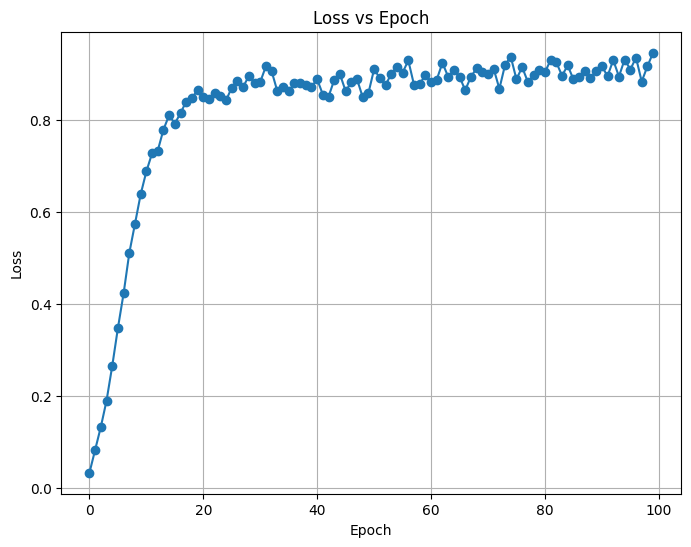

In [80]:
plt.figure(figsize=(8, 6))
plt.plot(list(range(num_epochs)), loss, marker="o", linestyle="-")
# plt.plot(list(range(num_epochs)), [-0.5 * jnp.log(1 - rho**2)]*len(loss), marker="o", linestyle="-")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()